<h1><center>Emoji'on : Reconnaissance des émotions</center></h1>
<h2><center>Part 4 : Deep Learning (CNN) & Data Augmentation</center></h2>
<center><img src="https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2F32cf5db1-69d0-4e21-8dec-710068e7a355.jpg&w=1280&q=75" alt="iIllustration" title="title"  style="object-fit:cover; width:800px; height:250px;"/></center>

> __*Created by Charley lebarbier*__

## Objectives :  
*Réaliser une application pour placer des émojis sur le visage de personnes détectés dans une vidéo en fonction de leur émotion.*  

## Livrables :  

- Notebook cohérent sur :  
    - l'analyse, 
    - la préparation des données, la création et l'entrainement du/des modèles et visualisation des performances  
</br>
- Application fonctionnelle

-----------------
-----------------

## Prepare the workspace

In [ ]:
# -- General Import
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# -- Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, Flatten, Dense, Dropout,\
                         BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory, to_categorical

# -- Other
from livelossplot import PlotLossesKeras
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
## -------------- Data Load -------------- ##
df = pd.read_csv('../data/fer2013.csv')

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Prepare Dataset

In [4]:
x_train, x_val, x_test = [], [], []
y_train, y_val, y_test = [], [], []

for idx, row in df.iterrows():
    img = row['pixels'].split(" ")            # - Get the img pixel

    if row['Usage'] == 'Training':
        x_train.append(np.array(img))         # - Convert img in array
        y_train.append(row['emotion'])        # - Get the img label

    elif row['Usage'] == 'PublicTest':
        x_val.append(np.array(img))
        y_val.append(row['emotion'])

    elif row['Usage'] == 'PrivateTest':
        x_test.append(np.array(img))
        y_test.append(row['emotion'])

In [5]:
# -- Convert in array for next step
x_train = np.array(x_train, dtype='float')
y_train = np.array(y_train)

x_val = np.array(x_val, dtype='float')
y_val = np.array(y_val)

x_test = np.array(x_test, dtype='float')
y_test = np.array(y_test)

In [6]:
# -- Reshape at the proper form for the model i.e. add 3 other dimensions
# -- 48, 48 (size of img) and 1 for the channel because graymode
# -- Then normalize it

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1) / 255.0
x_val = x_val.reshape(x_val.shape[0], 48, 48, 1) / 255.0
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1) / 255.0


# -- Reshape the target with the number of category

y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

## Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True,       # Reduce CNN result
)

train_datagen.fit(x_train)

## CNN

In [8]:
input_shape = (48, 48, 1)       # img size 48px on 48px, 1 channel = Grayscale
batch_size = 32

### Training / Validation

Pour notre modèle, nous réutilisons la même architecture que pour la partie 3. Néanmoins, nous modifions les callbacks.

In [9]:
cnn_model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64, (5,5), input_shape=input_shape, activation='elu',
         padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (5,5), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(256, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(512, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),

    tf.keras.layers.Dense(7, activation='softmax')
])

# -- Compilation
cnn_model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# -- Model Architecture
cnn_model.summary()

2023-02-20 16:03:10.938997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-20 16:03:10.944704: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-20 16:03:10.946669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UTILISA-DSORA5S): /proc/driver/nvidia/version does not exist
2023-02-20 16:03:10.960717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [10]:
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          verbose = 1,
                          restore_best_weights = True,
                          min_delta = 0.00005,
                          patience = 10),

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              verbose = 1,
                              factor = 0.5,
                              min_lr = 1e-7,
                              patience = 10,),

checkpoint = ModelCheckpoint('best_cnn_datAug.h5',
                             monitor = "val_loss",
                             verbose = 1,
                             save_best_only = True,
                             mode = "min"),

callbacks = [earlystop, reduce_lr, checkpoint, PlotLossesKeras()]

In [ ]:
## -- Décommenter pour calculer sinon utiliser le load ci-dessous


# essay_cnn_dataAug = cnn_model.fit_generator(
#         train_datagen.flow(x_train, y_train, batch_size=batch_size),
#         validation_data = (x_val, y_val),

#         epochs = 100,
#         step_per_epoch = len(x_train) / batch_size,

#         verbose = 1,
#         callbacks = callbacks,
#         use_multiprocessing = True
# )

Pour éviter les temps de calcul via le cpu, nous avons utilisé Colab pour switcher sur le GPU est ainsi gagner en temps d'exécution. Nous chargeons ici le modèle pré-entraîné pour la suite du notebook.

Infos Google Colab après entraînement :  
*loss: 0.7894 - accuracy: 0.7131 - val_loss: 0.8869 - val_accuracy: 0.6904 - lr: 2.5000e-04*  
*Epoch 68: early stoppingng*

In [11]:
# -- Model loading
cnn_model =  keras.models.load_model('../model_save/cnn_dataAug.h5')

### Test

In [12]:
y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

113/113 [==============================] - 76s 662ms/step


### Metrics & Confusion Matrix

In [13]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred, digits=3, zero_division=False))

              precision    recall  f1-score   support

           0      0.635     0.646     0.640       491
           1      0.597     0.673     0.632        55
           2      0.573     0.424     0.487       528
           3      0.900     0.893     0.897       879
           4      0.579     0.545     0.562       594
           5      0.766     0.779     0.772       416
           6      0.604     0.754     0.670       626

    accuracy                          0.692      3589
   macro avg      0.665     0.673     0.666      3589
weighted avg      0.691     0.692     0.688      3589



Text(95.72222222222221, 0.5, 'Truth')

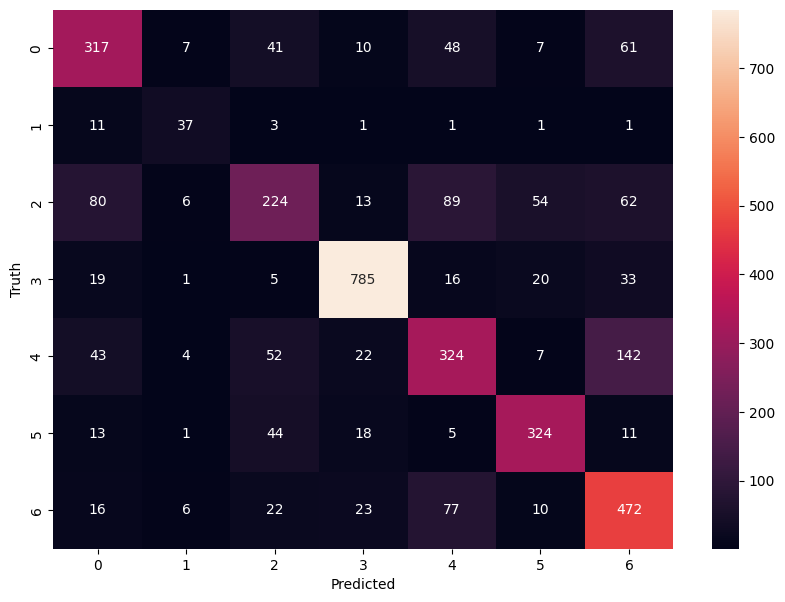

In [14]:
# -- get the x_test labels
y_actual = []

for a in y_test:
    y_actual.append(np.argmax(a))
y_actual[:10]


# -- Display the Confusion Matrix
cm = tf.math.confusion_matrix(labels=y_actual, predictions=y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Notre modèle fait un score de 69,2 % sur son jeu de test. Contrairement à la version sans Data Augmentation, nous arrivons à gagner environ 6%, ce qui n'est pas négligeable.  

Dans l'ensemble, chaque catégorie est assez bien détecter, nous pouvons comparer la prédiction / vérité via les images pour avoir un échantillon des principales erreurs pour avoir de plus ample informations.

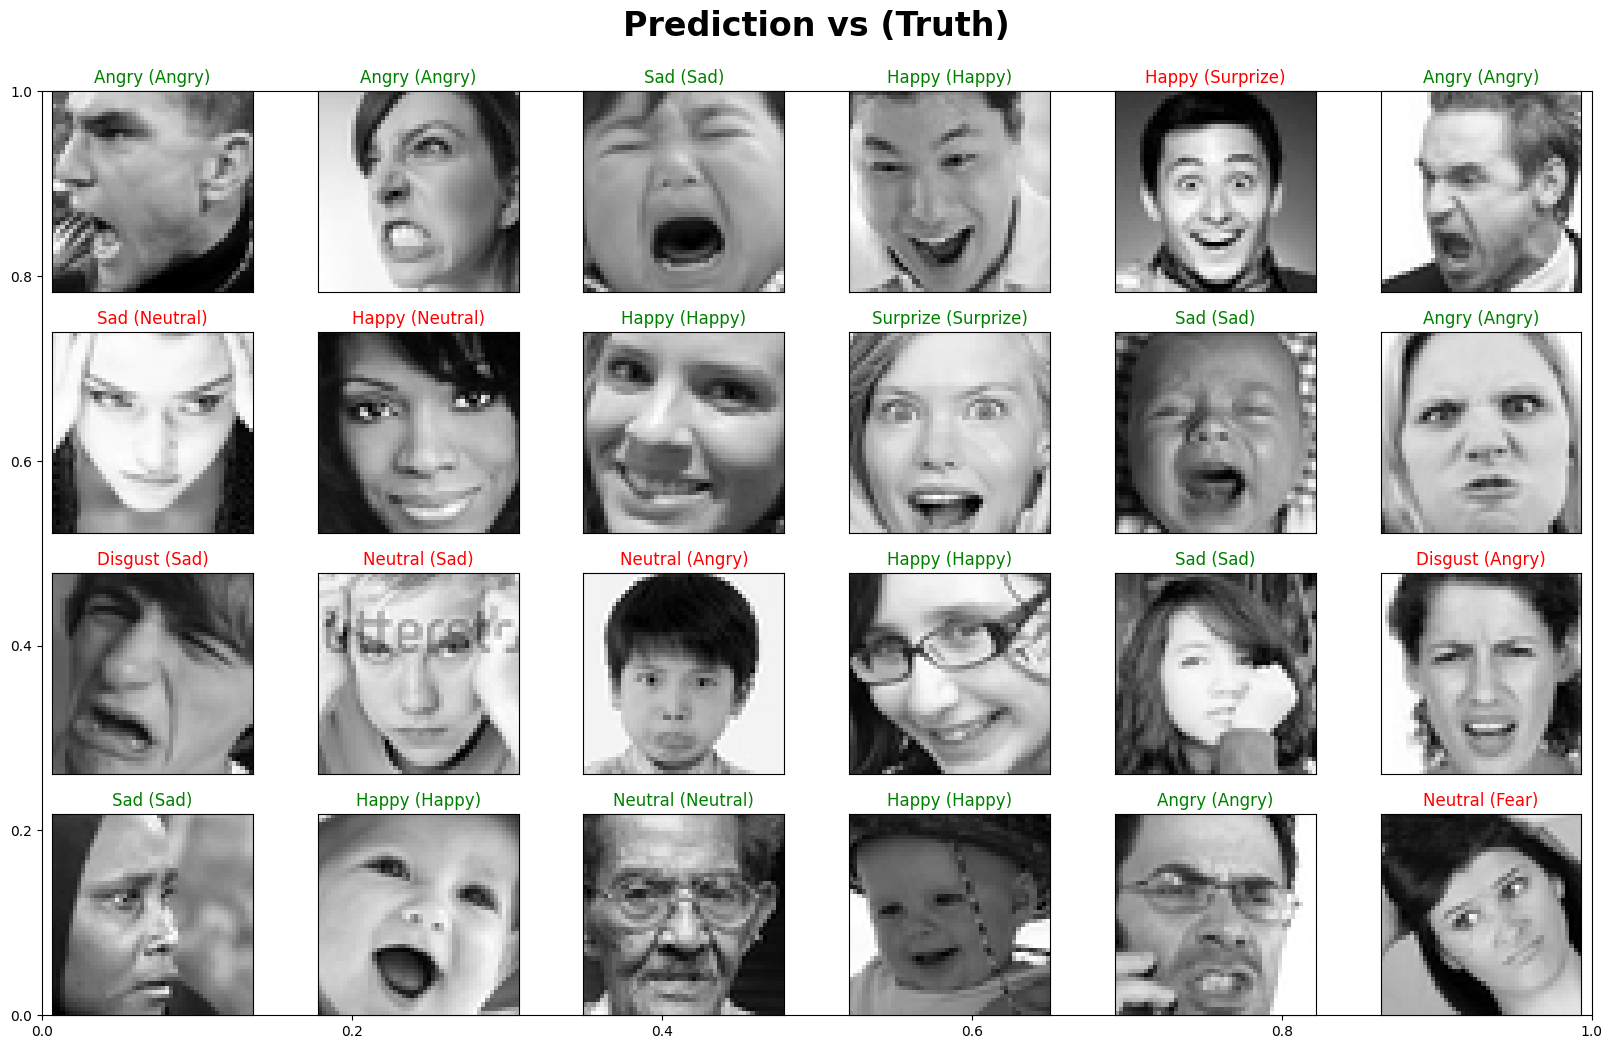

In [15]:
def check_images(x_test:np.ndarray, y_pred:np.ndarray) -> None:
    '''
    function to plot images with their lables (prediction vs (truth))
    '''

    # -- list of available emotions in the dataset
    emotions = { 0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad",
                 5:"Surprize", 6:"Neutral" }

    figure = plt.figure(figsize=(20, 12))
    plt.title("Prediction vs (Truth)",
              fontdict={'fontsize': 24, 'fontweight':'bold'}, pad=40)

    for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
        ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]),cmap="gray")

        predict_index = emotions[(y_pred[index])]
        true_index = emotions[np.argmax(y_test,axis=1)[index]]

        ax.set_title("{} ({})".format((predict_index), (true_index)),
                      color=("green" if predict_index == true_index else "red"))


check_images(x_test, y_pred)

Sur certaines photos, nous pouvons comprendre la confusion qu'il peut avoir.  

Une dernière solution qui peut être envisagée dans notre cas, est l'utilisation du Transfer Learning en se basant sur le modèle VGG-19 qui apportera très certainement de meilleurs performances.

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------